In [1]:
%tensorflow_version 1.x
import tensorflow as tf


TensorFlow 1.x selected.


In [2]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


# 0x0C. Neural Style Transfer

# 0. Initialize


Strangely enough, when that grid is a grid of pixel data, bicubic interpolation is a common method for resizing images!

Bicubic interpolation can also used in realtime rendering to make textures look nicer when scaled than standard bilinear texture interpolation.

This technique works when making images larger as well as smaller, but when making images smaller, you can still have problems with aliasing. There are are better algorithms to use when making an image smaller. Check the links section at the bottom for more details!

In [3]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image) # the image used as a style reference, stored as a numpy.ndarray
        self.content_image = self.scale_image(content_image) # the image used as a content reference, stored as a numpy.ndarray
        self.alpha = alpha # the weight for content cost
        self.beta = beta # the weight for style cost
    
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        """ SINON
        h, w, _ = image.shape
        if h > w:
            h_new = 512
            w_new = int(w * h_new / h)
        else:
            w_new = 512
            h_new = int(h * w_new / w)

        image = image[tf.newaxis, ...]
        image = tf.image.resize_bicubic(
            image,
            [h_new, w_new]
        )
        image = image / 255
        image = tf.clip_by_value(image, 0, 1)
        """



['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
block5_conv2
<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 320, 512, 3) 0.0 1.0
<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 343, 512, 3) 0.0 1.0
10000.0
1
True


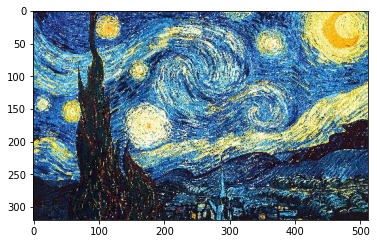

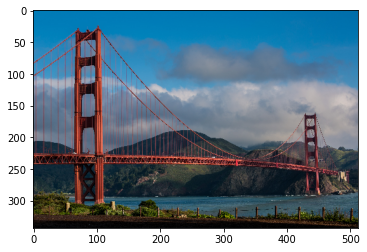

In [5]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    print(NST.style_layers)
    print(NST.content_layer)
    nst = NST(style_image, content_image)
    scaled_style = nst.scale_image(style_image)
    scaled_content = nst.scale_image(content_image)
    print(type(nst.style_image), nst.style_image.shape, np.min(nst.style_image),
               np.max(nst.style_image))
    print(type(nst.content_image), nst.content_image.shape, np.min(nst.content_image),
               np.max(nst.content_image))
    print(nst.alpha)
    print(nst.beta)
    print(tf.executing_eagerly())
    assert(np.array_equal(scaled_style, nst.style_image))
    assert(np.array_equal(scaled_content, nst.content_image))

    plt.imshow(nst.style_image[0])
    plt.show()
    plt.imshow(nst.content_image[0])
    plt.show()


# 1. Load the Model 

In [6]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()

    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
        """
 
        custom_objects = {'MaxPooling2D': tf.keras.layers.AveragePooling2D}
        vgg.save('source_model')
        custom_model = tf.keras.models.load_model(
            'source_model',
            custom_objects=custom_objects
        )

        custom_model.trainable = False
        for layer in custom_model.layers:
            layer.trainable = False

        s_outputs = [
            custom_model.get_layer(name).output for name in self.style_layers
        ]
        c_output = custom_model.get_layer(self.content_layer).output
        outputs = s_outputs + [c_output]
        self.model = tf.keras.models.Model(custom_model.input, outputs)
        """
    

In [7]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [8]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [9]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    nst = NST(style_image, content_image)
    nst.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0     

# 2. Gram Matrix 

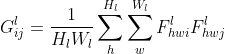

In [10]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.model = self.load_model()

    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    """
    @staticmethod
    def gram_matrix(input_layer):
        # The rank of a tensor is the number of indices required to uniquely select each element of the tensor. Rank is also known as "order", "degree", or "ndims"
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
        c = int(input_layer.shape[-1])
        a = tf.reshape(input_layer, [-1, c])
        n = tf.shape(a)[0]
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(n, tf.float32)
    """
    """
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)
    """
    
    @staticmethod
    def gram_matrix(input_layer):

        if not isinstance(input_layer, (tf.Tensor, tf.Variable))\
                or tf.rank(input_layer).numpy() != 4:
            raise TypeError('input_layer must be a tensor of rank 4')

        _, h, w, c = tf.shape(input_layer).numpy()
        F = tf.reshape(input_layer, (1, -1, c))
        n = tf.shape(F)[1]
        gram = tf.matmul(F, F, transpose_a=True)
        return gram / tf.cast(n, tf.float32)
    

We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix Gˡ, where Gˡᵢⱼ is the inner product between the vectorized feature map i and j in layer l. We can see that Gˡᵢⱼ generated over the feature map for a given image represents the correlation between feature maps i and j.

In [11]:

if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    np.random.seed(0)
    nst = NST(style_image, content_image)
    input_layer = tf.constant(np.random.randn(1, 28, 30, 3), dtype=tf.float32)
    gram_matrix = nst.gram_matrix(input_layer)
    print(gram_matrix)

tf.Tensor(
[[[ 0.92385894 -0.04459446  0.01773124]
  [-0.04459446  0.9918023  -0.03037722]
  [ 0.01773124 -0.03037722  0.9517656 ]]], shape=(1, 3, 3), dtype=float32)


# 3. Extract Features 

In [12]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    """
    Public Instance Method: def generate_features(self):
    extracts the features used to calculate neural style cost
    Sets the public instance attributes:
    gram_style_features - a list of gram matrices calculated from the style layer outputs of the style image
    content_feature - the content layer output of the content image
    """

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
 

In [13]:
if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    nst = NST(style_image, content_image)
    print(nst.gram_style_features)
    print(nst.content_feature)


[<tf.Tensor: id=2761, shape=(1, 64, 64), dtype=float32, numpy=
array([[[10117.937  ,  3632.9949 ,  2837.061  , ...,  2320.762  ,
          2786.7412 ,  4394.7983 ],
        [ 3632.9949 ,  6109.1045 ,  2801.3657 , ...,  1546.3984 ,
          2895.7065 ,  2676.98   ],
        [ 2837.061  ,  2801.3657 ,  2320.755  , ...,   404.45453,
          2576.8477 ,  3001.9785 ],
        ...,
        [ 2320.762  ,  1546.3984 ,   404.45453, ..., 11506.09   ,
          1703.8668 ,  1146.6345 ],
        [ 2786.7412 ,  2895.7065 ,  2576.8477 , ...,  1703.8668 ,
          5416.046  ,  4916.1455 ],
        [ 4394.7983 ,  2676.98   ,  3001.9785 , ...,  1146.6345 ,
          4916.1455 ,  5770.69   ]]], dtype=float32)>, <tf.Tensor: id=2771, shape=(1, 128, 128), dtype=float32, numpy=
array([[[1.0340007e+03, 1.6785077e+02, 2.0454917e+00, ...,
         9.6093689e+02, 6.6789148e+02, 2.8331915e+02],
        [1.6785077e+02, 2.7325260e+04, 1.1075416e+04, ...,
         3.3825312e+04, 1.9214223e+04, 1.1647773e+04],
 

# 4. Layer Style Cost

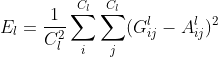

In [14]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
        

    """
    Public Instance Method: def layer_style_cost(self, style_output, gram_target):
    Calculates the style cost for a single layer
    style_output - tf.Tensor of shape (1, h, w, c) containing the layer style output of the generated image
    gram_target - tf.Tensor of shape (1, c, c) the gram matrix of the target style output for that layer
    if style_output is not an instance of tf.Tensor or tf.Variable of rank 4, raise a TypeError with the message style_output must be a tensor of rank 4
    if gram_target is not an instance of tf.Tensor or tf.Variable with shape (1, c, c), raise a TypeError with the message gram_target must be a tensor of shape [1, {c}, {c}] where {c} is the number of channels in style_output
    Returns: the layer’s style cost
    """
    def layer_style_cost(self, style_output, gram_target):
      
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))

        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))


In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    nst = NST(style_image, content_image)
    np.random.seed(0)
    vgg19 = tf.keras.applications.vgg19
    preprocecced = vgg19.preprocess_input(nst.content_image * 255)
    outputs = nst.model(preprocecced)
    layer_style_cost = nst.layer_style_cost(outputs[0], nst.gram_style_features[0])
    print(layer_style_cost)



tf.Tensor(3239105.0, shape=(), dtype=float32)


# 5. Style Cost


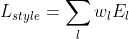

In [16]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
        
    def layer_style_cost(self, style_output, gram_target):
      
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))

        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))



    def style_cost(self, style_outputs):
        if type(style_outputs) is not list or len(style_outputs) != len(self.style_layers):
            raise TypeError('style_outputs must be a list with a length of {}'.format(len(self.style_layers)))
        J_style = tf.add_n([self.layer_style_cost(style_outputs[i], self.gram_style_features[i]) for i in range(len(style_outputs))])
        J_style /= tf.cast(len(style_outputs), tf.float32)
        return J_style


In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#!/usr/bin/env python3
"""
Main file
"""
import tensorflow as tf
import tensorflow.keras as K
tf.enable_eager_execution()# Force Seed - fix for Keras
SEED = 0
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
tf.set_random_seed(SEED)#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.backend.set_session(sess)
#tf.enable_eager_execution()import matplotlib.image as mpimgNST = __import__('5-neural_style').NSTif __name__ == '__main__':
#tf.enable_eager_execution()
style_image = np.random.uniform(0, 256, size=(1000, 1000, 3))
content_image = np.random.uniform(0, 256, size=(500, 1000, 3))   
nst = NST(style_image, content_image)
np.random.seed(0)
vgg19 = tf.keras.applications.vgg19    
preprocecced = vgg19.preprocess_input(nst.content_image * 255)
style_outputs = nst.model(preprocecced)[:-1]
style_cost = nst.style_cost(style_outputs)
print(style_cost)

tf.Tensor(1064273.1, shape=(), dtype=float32)


In [18]:
np.abs(1064272.8-1064264.8)/1064264.8

7.516926238657898e-06

# 6-content loss

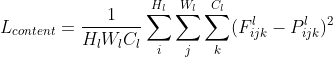

In [19]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
        
    def layer_style_cost(self, style_output, gram_target):
      
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))

        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))


    def style_cost(self, style_outputs):
        if type(style_outputs) is not list or len(style_outputs) != len(self.style_layers):
            raise TypeError('style_outputs must be a list with a length of {}'.format(len(self.style_layers)))
        J_style = tf.add_n([self.layer_style_cost(style_outputs[i], self.gram_style_features[i]) for i in range(len(style_outputs))])
        J_style /= tf.cast(len(style_outputs), tf.float32)
        return J_style

    
    def content_cost(self, content_output):
        if not (isinstance(content_output, tf.Tensor) or isinstance(content_output, tf.Variable)) or content_output.shape.dims != self.content_feature.shape.dims:
            raise TypeError('content_output must be a tensor of shape {}'.format(self.content_feature.shape))
        _, nh, nw, nc = content_output.shape.dims
        return tf.reduce_sum(tf.square(content_output - self.content_feature)) / tf.cast(nh * nw * nc, tf.float32)
    """
    def content_cost(self, content_output):

        c_feature = self.content_feature
        if not isinstance(content_output, (tf.Tensor, tf.Variable))\
                or content_output.shape != c_feature.shape:
            raise TypeError('content_output must be a tensor of shape {}'.
                            format(c_feature.shape))
        return tf.reduce_mean(tf.square(content_output - c_feature))
    """

In [20]:
if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    np.random.seed(0)
    nst = NST(style_image, content_image)
    generated_image = np.random.uniform(size=nst.content_image.shape)
    generated_image = generated_image.astype('float32')
    vgg19 = tf.keras.applications.vgg19
    preprocecced = vgg19.preprocess_input(generated_image * 255)
    outputs = nst.model(preprocecced)
    content_output = outputs[-1]
    content_cost = nst.content_cost(content_output)
    print(content_cost)

tf.Tensor(113.58054, shape=(), dtype=float32)


# 7. Total Cost


image.png

In [21]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
        
    def layer_style_cost(self, style_output, gram_target):
      
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))

        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))


    def style_cost(self, style_outputs):
        if type(style_outputs) is not list or len(style_outputs) != len(self.style_layers):
            raise TypeError('style_outputs must be a list with a length of {}'.format(len(self.style_layers)))
        J_style = tf.add_n([self.layer_style_cost(style_outputs[i], self.gram_style_features[i]) for i in range(len(style_outputs))])
        J_style /= tf.cast(len(style_outputs), tf.float32)
        return J_style


    def content_cost(self, content_output):
        if not (isinstance(content_output, tf.Tensor) or isinstance(content_output, tf.Variable)) or content_output.shape.dims != self.content_feature.shape.dims:
            raise TypeError('content_output must be a tensor of shape {}'.format(self.content_feature.shape))
        _, nh, nw, nc = content_output.shape.dims
        return tf.reduce_sum(tf.square(content_output - self.content_feature)) / tf.cast(nh * nw * nc, tf.float32)


    def total_cost(self, generated_image):
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        preprocessed = tf.keras.applications.vgg19.preprocess_input(generated_image * 255)
        model_outputs = self.model(preprocessed)
        style_outputs = [style_layer for style_layer in model_outputs[:-1]]
        content_output = model_outputs[-1]

        J_style = self.style_cost(style_outputs)
        J_content = self.content_cost(content_output)
        J = (self.alpha * J_content) + (self.beta * J_style)
        return J, J_content, J_style

In [22]:
if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    np.random.seed(0)
    nst = NST(style_image, content_image)
    generated_image = np.random.uniform(size=nst.content_image.shape)
    generated_image = tf.cast(generated_image, tf.float32)
    J_total, J_content, J_style = nst.total_cost(generated_image)
    print(J_total)
    print(J_content)
    print(J_style)

tf.Tensor(1662946600.0, shape=(), dtype=float32)
tf.Tensor(113.58054, shape=(), dtype=float32)
tf.Tensor(1661810800.0, shape=(), dtype=float32)


#8. Compute Gradients


In [23]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
        
    def layer_style_cost(self, style_output, gram_target):
      
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))

        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))


    def style_cost(self, style_outputs):
        if type(style_outputs) is not list or len(style_outputs) != len(self.style_layers):
            raise TypeError('style_outputs must be a list with a length of {}'.format(len(self.style_layers)))
        J_style = tf.add_n([self.layer_style_cost(style_outputs[i], self.gram_style_features[i]) for i in range(len(style_outputs))])
        J_style /= tf.cast(len(style_outputs), tf.float32)
        return J_style


    def content_cost(self, content_output):
        if not (isinstance(content_output, tf.Tensor) or isinstance(content_output, tf.Variable)) or content_output.shape.dims != self.content_feature.shape.dims:
            raise TypeError('content_output must be a tensor of shape {}'.format(self.content_feature.shape))
        _, nh, nw, nc = content_output.shape.dims
        return tf.reduce_sum(tf.square(content_output - self.content_feature)) / tf.cast(nh * nw * nc, tf.float32)


    def total_cost(self, generated_image):
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        preprocessed = tf.keras.applications.vgg19.preprocess_input(generated_image * 255)
        model_outputs = self.model(preprocessed)
        style_outputs = [style_layer for style_layer in model_outputs[:-1]]
        content_output = model_outputs[-1]

        J_style = self.style_cost(style_outputs)
        J_content = self.content_cost(content_output)
        J = (self.alpha * J_content) + (self.beta * J_style)
        return J, J_content, J_style


    def compute_grads(self, generated_image):
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        with tf.GradientTape() as tape:
            tape.watch(generated_image)
            J, J_content, J_style = self.total_cost(generated_image)
        grads = tape.gradient(J, generated_image)
        return grads, J, J_content, J_style

In [24]:
if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    np.random.seed(0)
    nst = NST(style_image, content_image)
    generated_image = tf.contrib.eager.Variable(nst.content_image)
    grads, J_total, J_content, J_style = nst.compute_grads(generated_image)
    print(J_total)
    print(J_content)
    print(J_style)
    print(grads)
    

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

tf.Tensor(2547305200.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(2547305200.0, shape=(), dtype=float32)
tf.Tensor(
[[[[-33734.645   -33019.418    -5820.8867 ]
   [-39225.723   -41287.79      2747.75   ]
   [-47754.906   -56826.97     -1177.0042 ]
   ...
   [-37313.64    -27446.998    -6036.9165 ]
   [-53454.777   -45679.426   -16942.14   ]
   [-26092.361   -22006.447    -1149.2574 ]]

  [[-32580.326   -28911.053     3999.58   ]
   [-17056.34    -17322.34     35779.76   ]
   [-33409.47    -48955.03     24575.707  ]
   ...
   [ -5060.36     14107.242    24705.24   ]
   [-51268.098   -37455.273    

# 9. Generate Image

In [28]:
#!/usr/bin/env python3
import numpy as np
import tensorflow as tf
"""
class NST that performs tasks for neural style transfer:
"""


class NST:
    """ NST """

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']
    content_layer = 'block5_conv2'

    def __init__(self, style_image, content_image, alpha=1e4, beta=1):

        #tf.enable_eager_execution()

        if type(style_image) != np.ndarray or style_image.ndim != 3 or style_image.shape[2] != 3:
            raise TypeError ("style_image must be a numpy.ndarray with shape (h, w, 3)")
        if type(content_image) != np.ndarray or content_image.ndim != 3 or content_image.shape[2] != 3:
            raise TypeError ("content_image must be a numpy.ndarray with shape (h, w, 3)")
        if (type(alpha) is not int and type(alpha) is not float) or alpha < 0:
            raise TypeError('alpha must be a non-negative number')
        if (type(beta) is not int and type(beta) is not float) or beta < 0:
            raise TypeError('beta must be a non-negative number')


        self.style_image = self.scale_image(style_image)
        self.content_image = self.scale_image(content_image)
        self.alpha = alpha
        self.beta = beta
        self.load_model()
        self.generate_features()
    @staticmethod
    def scale_image(image):
        if type(image) != np.ndarray or image.ndim != 3 or image.shape[2] != 3:
            raise TypeError ("image must be a numpy.ndarray with shape (h, w, 3)")

        max_dims = 512
        shape = image.shape[:2]
        scale = max_dims / max(shape[0], shape[1])
        new_shape = (int(scale * shape[0]), int(scale * shape[1]))
        image = np.expand_dims(image, axis=0)
        image = tf.clip_by_value(tf.image.resize_bicubic(image, new_shape) / 255, 0, 1)
        return image
        
    def load_model(self):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        x = vgg.input
        model_outputs = []
        content_output = None
        for layer in vgg.layers[1:]:
            if "pool" in layer.name:
                x = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size, strides=layer.strides, name=layer.name)(x)
            else:
                x = layer(x)
                if layer.name in self.style_layers:
                    model_outputs.append(x)
                if layer.name == self.content_layer:
                    content_output = x
                layer.trainable = False
        model_outputs.append(content_output)
        model = tf.keras.models.Model(vgg.input, model_outputs)
        self.model = model
    
    @staticmethod
    def gram_matrix(input_layer):
        if not (isinstance(input_layer, tf.Tensor) or isinstance(input_layer, tf.Variable)) or input_layer.shape.ndims != 4:
            raise TypeError('input_layer must be a tensor of rank 4')
       #input_layer: containing the layer output whose gram matrix should be calculated
        _, nh, nw, _ = input_layer.shape.dims
        G = tf.linalg.einsum('bijc,bijd->bcd', input_layer, input_layer)
        return G / tf.cast(nh * nw, tf.float32)

    def generate_features(self):
        preprocessed_s = tf.keras.applications.vgg19.preprocess_input(self.style_image * 255)
        preprocessed_c = tf.keras.applications.vgg19.preprocess_input(self.content_image * 255)
        style_features = self.model(preprocessed_s)[:-1]
        self.content_feature = self.model(preprocessed_c)[-1]
        self.gram_style_features = [self.gram_matrix(style_feature) for style_feature in style_features]
        
    def layer_style_cost(self, style_output, gram_target):
      
        if not (isinstance(style_output, tf.Tensor) or isinstance(style_output, tf.Variable)) or style_output.shape.ndims != 4:
            raise TypeError('style_output must be a tensor of rank 4')
        m, _, _, nc = style_output.shape.dims
        if not (isinstance(gram_target, tf.Tensor) or isinstance(gram_target, tf.Variable)) or gram_target.shape.dims != [m, nc, nc]:
            raise TypeError('gram_target must be a tensor of shape [{}, {}, {}]'.format(m, nc, nc))

        gram_style = self.gram_matrix(style_output)
        return tf.reduce_sum(tf.square(gram_style - gram_target)) / tf.square(tf.cast(nc, tf.float32))


    def style_cost(self, style_outputs):
        if type(style_outputs) is not list or len(style_outputs) != len(self.style_layers):
            raise TypeError('style_outputs must be a list with a length of {}'.format(len(self.style_layers)))
        J_style = tf.add_n([self.layer_style_cost(style_outputs[i], self.gram_style_features[i]) for i in range(len(style_outputs))])
        J_style /= tf.cast(len(style_outputs), tf.float32)
        return J_style


    def content_cost(self, content_output):
        if not (isinstance(content_output, tf.Tensor) or isinstance(content_output, tf.Variable)) or content_output.shape.dims != self.content_feature.shape.dims:
            raise TypeError('content_output must be a tensor of shape {}'.format(self.content_feature.shape))
        _, nh, nw, nc = content_output.shape.dims
        return tf.reduce_sum(tf.square(content_output - self.content_feature)) / tf.cast(nh * nw * nc, tf.float32)


    def total_cost(self, generated_image):
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        preprocessed = tf.keras.applications.vgg19.preprocess_input(generated_image * 255)
        model_outputs = self.model(preprocessed)
        style_outputs = [style_layer for style_layer in model_outputs[:-1]]
        content_output = model_outputs[-1]

        J_style = self.style_cost(style_outputs)
        J_content = self.content_cost(content_output)
        J = (self.alpha * J_content) + (self.beta * J_style)
        return J, J_content, J_style


    def compute_grads(self, generated_image):
        if not (isinstance(generated_image, tf.Tensor) or isinstance(generated_image, tf.Variable)) or generated_image.shape.dims != self.content_image.shape.dims:
            raise TypeError('generated_image must be a tensor of shape {}'.format(self.content_image.shape))
        with tf.GradientTape() as tape:
            tape.watch(generated_image)
            J, J_content, J_style = self.total_cost(generated_image)
        grads = tape.gradient(J, generated_image)
        return grads, J, J_content, J_style


    def generate_image(self, iterations=1000, step=None, lr=0.01, beta1=0.9, beta2=0.99):
        if type(iterations) is not int:
            raise TypeError('iterations must be an integer')
        if iterations < 1:
            raise ValueError('iterations must be positive')
        if step is not None and type(step) is not int:
            raise TypeError('step must be an integer')
        if step is not None and not 0 < step < iterations:
            raise ValueError('step must be positive and less than iterations')
        if type(lr) is not float and type(lr) is not int:
            raise TypeError('lr must be a number')
        if lr <= 0:
            raise ValueError('lr must be positive')
        if type(beta1) is not float:
            raise TypeError('beta1 must be a float')
        if not 0 <= beta1 <= 1:
            raise ValueError('beta1 must be in the range [0, 1]')
        if type(beta2) is not float:
            raise TypeError('beta2 must be a float')
        if not 0 <= beta2 <= 1:
            raise ValueError('beta2 must be in the range [0, 1]')
        generated_image = tf.contrib.eager.Variable(self.content_image)
        optimizer = tf.train.AdamOptimizer(lr, beta1, beta2)
        best_cost = np.inf
        best_image = None
        for i in range(iterations):
            grads, J, J_content, J_style = self.compute_grads(generated_image)
            if step is not None and i % step == 0:
                print("Cost at iteration {}: {}, content {}, style {}".format(i, J, J_content, J_style))
            if J < best_cost:
                best_cost = J.numpy()
                best_image = generated_image.numpy()[0]
            optimizer.apply_gradients([(grads, generated_image)])
            generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
            
        _, J, J_content, J_style = self.compute_grads(generated_image)
        if J < best_cost:
            best_cost = J.numpy()
            best_image = generated_image.numpy()[0]
        if step is not None:
            print("Cost at iteration {}: {}, content {}, style {}".format(iterations, J, J_content, J_style))
        return best_image, best_cost

Cost at iteration 0: 2547305216.0, content 0.0, style 2547305216.0
Cost at iteration 100: 113617352.0, content 104.21326446533203, style 112575216.0
Cost at iteration 200: 42306712.0, content 116.16024017333984, style 41145108.0
Cost at iteration 300: 21478552.0, content 119.67720794677734, style 20281780.0
Cost at iteration 400: 11859072.0, content 120.98699188232422, style 10649202.0
Cost at iteration 500: 7151895.5, content 120.04643249511719, style 5951431.0
Cost at iteration 600: 4749573.5, content 116.18150329589844, style 3587758.5
Cost at iteration 700: 3422406.75, content 109.5378189086914, style 2327028.5
Cost at iteration 800: 2608267.5, content 102.0500259399414, style 1587767.25
Cost at iteration 900: 2108850.5, content 95.02938079833984, style 1158556.625
Cost at iteration 1000: 1806951.125, content 88.99486541748047, style 917002.5
Cost at iteration 1100: 1589268.5, content 84.24224853515625, style 746845.9375
Cost at iteration 1200: 1451002.375, content 80.4550704956054

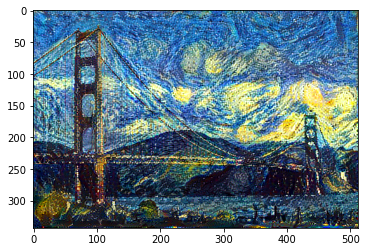

In [29]:
if __name__ == '__main__':
    style_image = mpimg.imread("starry_night.jpg")
    content_image = mpimg.imread("golden_gate.jpg")

    np.random.seed(0)
    nst = NST(style_image, content_image)
    image, cost = nst.generate_image(iterations=2000, step=100, lr=0.002)
    print("Best cost:", cost)
    plt.imshow(image)
    plt.show()

# Test:

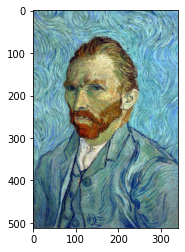

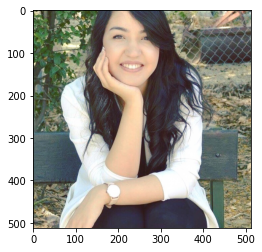

Cost at iteration 0: 465494336.0, content 0.0, style 465494336.0
Cost at iteration 100: 13040581.0, content 84.03186798095703, style 12200262.0
Cost at iteration 200: 7088894.0, content 81.89378356933594, style 6269956.0
Cost at iteration 300: 4693733.0, content 76.59674835205078, style 3927765.5
Cost at iteration 400: 3267994.5, content 70.10618591308594, style 2566932.75
Cost at iteration 500: 2302312.0, content 63.553653717041016, style 1666775.375
Cost at iteration 600: 1664665.125, content 57.2276496887207, style 1092388.625
Cost at iteration 700: 1267905.625, content 51.575687408447266, style 752148.75
Cost at iteration 800: 1035183.5, content 47.295719146728516, style 562226.3125
Cost at iteration 900: 885709.625, content 44.063602447509766, style 445073.5625
Cost at iteration 1000: 796330.5, content 41.78136444091797, style 378516.8125
Cost at iteration 1100: 725773.0, content 40.074920654296875, style 325023.8125
Cost at iteration 1200: 680180.5, content 38.68023681640625, sty

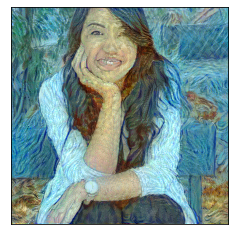

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
if __name__ == '__main__':
    style_image = mpimg.imread("/content/Autoportrait.jpg")
    content_image = mpimg.imread("/content/oumaima.jpg")

    np.random.seed(0)
    nst = NST(style_image, content_image)

    
    plt.imshow(nst.style_image[0])
    plt.show()
    plt.imshow(nst.content_image[0])
    plt.show()

    image, cost = nst.generate_image(iterations=2000, step=100, lr=0.002)
    print("Best cost:", cost)

    plt.imshow(image)
    
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    plt.savefig('Oumaima_Style.jpg')
